In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit
from statsmodels.formula.api import ols

import causalpy as cp

%load_ext autoreload
%autoreload 2

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc_extras/model/marginal/graph_analysis.py:10: FutureWarning: `pytensor.graph.basic.io_toposort` was moved to `pytensor.graph.traversal.io_toposort`. Calling it from the old location will fail in a future release.
  from pytensor.graph.basic import io_toposort


In [2]:
sample_kwargs = {
    "draws": 1000,
    "tune": 2000,
    "chains": 4,
    "cores": 4,
    "target_accept": 0.95,
    "progressbar": True,
    "random_seed": 42,
    "nuts_sampler": "numpyro",
}

## Variable Selection Priors and Instrumental Variable Designs

When building causal inference models, we face a fundamental dilemma: the bias-variance trade-off. We are tasked with finding the true causal effect of a treatment ($T$) on an outcome ($Y$) while controlling for every single confounder ($X$)—variables that influence both $T$ and $Y$. Include too few variables, and we risk the catastrophic flaw of omitted variable bias (OVB), leading to inaccurate causal claims.Include too many irrelevant variables (noise), and we introduce noise that inflates our uncertainty, widens our posterior intervals, or, worse, creates multicollinearity that destabilizes our estimates.Traditional approaches force us to make hard, upfront decisions about which $X$'s to include. In ideal cases, this is driven by theory. But in the messy reality of data science, where we often have dozens of "potential" confounders, how do we make this choice?

We want to let the data help us make these decisions while still maintaining the principled probabilistic framework of Bayesian inference. This is where variable selection priors enter the scene. They allow us to encode our uncertainty about variable relevance directly into the prior, making variable selection part of the inference problem itself, not a separate, error-prone preprocessing step.

Let's first simulate some data with some natural confounding structure and a known true treatment effect of 3.0. We enforce the idea of confounding on the treatment effect with a positive selection probability driving treatment and outcome. The challenge of modelling this data is to tease out the structure of the simultaneous equations in the system. For more details on this Bayesian structural causal modelling [see here](https://causalpy.readthedocs.io/en/latest/knowledgebase/structural_causal_models.html)


In [3]:
def simulate_data(n=2500, alpha_true=3.0, rho=0.6, cate_estimation=False, n_zeros=50):
    # Exclusion restrictions:
    # X[0], X[1] affect both Y and T (confounders)
    # X[2], X[3] affect ONLY T (instruments for T)
    # X[4] affects ONLY Y (predictor of Y only)

    betaY_core = np.array([0.5, -0.3, 0.0, 0.0, 0.4])
    betaD_core = np.array([0.7, 0.1, -0.4, 0.3, 0.0])

    betaY = np.concatenate([betaY_core, np.zeros(n_zeros)])
    betaD = np.concatenate([betaD_core, np.zeros(n_zeros)])

    p = len(betaY)

    # noise variances and correlation
    sigma_U = 1
    sigma_V = 1

    # design matrix (n × p) with mean-zero columns
    X = np.random.normal(size=(n, p))
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    mean = [0, 0]
    cov = [[sigma_U**2, rho * sigma_U * sigma_V], [rho * sigma_U * sigma_V, sigma_V**2]]
    errors = np.random.multivariate_normal(mean, cov, size=n)
    U = errors[:, 0]  # error in outcome equation
    V = errors[:, 1]  #

    # continuous treatment
    T_cont = X @ betaD + V

    # latent variable for binary treatment
    T_latent = X @ betaD + V
    T_bin = np.random.binomial(n=1, p=expit(T_latent), size=n)

    alpha_individual = 3.0 + 2.5 * X[:, 0]

    # outcomes
    Y_cont = alpha_true * T_cont + X @ betaY + U
    if cate_estimation:
        Y_bin = alpha_individual * T_bin + X @ betaY + U
    else:
        Y_bin = alpha_true * T_bin + X @ betaY + U

    # combine into DataFrame
    data = pd.DataFrame(
        {
            "Y_cont": Y_cont,
            "Y_bin": Y_bin,
            "T_cont": T_cont,
            "T_bin": T_bin,
        }
    )
    data["alpha"] = alpha_true + alpha_individual
    for j in range(p):
        data[f"feature_{j}"] = X[:, j]
    data["Y_cont_scaled"] = (data["Y_cont"] - data["Y_cont"].mean()) / data[
        "Y_cont"
    ].std(ddof=1)
    data["Y_bin_scaled"] = (data["Y_bin"] - data["Y_bin"].mean()) / data["Y_bin"].std(
        ddof=1
    )
    data["T_cont_scaled"] = (data["T_cont"] - data["T_cont"].mean()) / data[
        "T_cont"
    ].std(ddof=1)
    data["T_bin_scaled"] = (data["T_bin"] - data["T_bin"].mean()) / data["T_bin"].std(
        ddof=1
    )
    return data


data = simulate_data(n_zeros=20)
instruments_data = data.copy()
features = [col for col in data.columns if "feature" in col]
formula = "Y_cont ~ T_cont + " + " + ".join(features)
instruments_formula = "T_cont ~ 1 + " + " + ".join(features)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 34 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Y_cont         2500 non-null   float64
 1   Y_bin          2500 non-null   float64
 2   T_cont         2500 non-null   float64
 3   T_bin          2500 non-null   int64  
 4   alpha          2500 non-null   float64
 5   feature_0      2500 non-null   float64
 6   feature_1      2500 non-null   float64
 7   feature_2      2500 non-null   float64
 8   feature_3      2500 non-null   float64
 9   feature_4      2500 non-null   float64
 10  feature_5      2500 non-null   float64
 11  feature_6      2500 non-null   float64
 12  feature_7      2500 non-null   float64
 13  feature_8      2500 non-null   float64
 14  feature_9      2500 non-null   float64
 15  feature_10     2500 non-null   float64
 16  feature_11     2500 non-null   float64
 17  feature_12     2500 non-null   float64
 18  feature_

CausalPy's  `Variable Selection` module provides a way to encode our uncertainty about variable relevance directly into the prior distribution. Rather than choosing which predictors to include, we specify priors that allow coefficients to be shrunk toward zero (or exactly zero) when the data doesn't support their inclusion. The key insight is that variable selection becomes part of the inference problem rather than a preprocessing step. The module offers two fundamentally different approaches to variable selection, each reflecting a different belief about how sparsity manifests in the world. For references to a discussion of variable selection priors we direct the reader to {cite:t}`kaplan_bs_social_science`

#### The Spike-and-Slab: Discrete Choices

The inclusion probability is shared across coefficients and given a Beta prior:

$$
\pi \sim \text{Beta}(\alpha_\pi, \beta_\pi).
$$

This parameter represents the prior probability that a coefficient is non-zero. For example, $\alpha_\pi = \beta_\pi = 2$ corresponds to a weakly informative prior centered at $0.5$.

#### Relaxed Bernoulli approximation

To enable efficient gradient-based sampling, the binary indicator $\gamma_j$ is approximated using a continuous relaxation of the Bernoulli distribution. Specifically,

$$
\gamma_j = \text{sigmoid} \left(
\frac{logit(\pi) + log (u_j) - log(1 - u_j)}{T}
\right),
\qquad
u_j \sim \text{Uniform}(0,1),
$$

where $T > 0$ is a temperature parameter. As $T \to 0$, this approximation approaches a discrete Bernoulli distribution, while larger values of $T$ yield smoother transitions.

This relaxed formulation allows the model to learn inclusion probabilities while remaining compatible with Hamiltonian Monte Carlo.

#### Interpretation

- Coefficients with posterior $\gamma_j$ concentrated near zero are effectively excluded.
- Coefficients with posterior $\gamma_j$ concentrated near one are included.
- Posterior means of $\gamma_j$ can be interpreted as **variable inclusion probabilities**.

The spike-and-slab prior is most appropriate when the goal is **explicit variable selection** and when sparsity is expected.

---

#### The Regularised Horseshoe: Gentle Moderation

The horseshoe prior takes a different philosophical stance. Instead of discrete selection, it says: effects exist on a continuum from negligible to substantial, and we should shrink them proportionally to their signal strength. Small effects get heavily shrunk (possibly to near-zero), while large effects escape shrinkage almost entirely.

#### Horseshoe Prior

The horseshoe prior is a continuous shrinkage prior designed for sparse or near-sparse signals. Unlike spike-and-slab, it does not explicitly set coefficients to zero, but instead shrinks most coefficients strongly toward zero while allowing a small number of large signals to escape shrinkage.

Each coefficient is modeled as

$$
\beta_j = \tau \cdot \tilde{\lambda}_j \cdot \beta_j^{\text{raw}},
\qquad
\beta_j^{\text{raw}} \sim \mathcal{N}(0,1).
$$

#### Global shrinkage

The global shrinkage parameter $\tau$ controls the overall level of shrinkage applied to all coefficients:

$$
\tau \sim \text{Half-Student-}t(\nu, \tau_0).
$$

Smaller values of $\tau$ result in stronger overall shrinkage. When not specified manually, $\tau_0$ may be set using a data-adaptive rule of thumb based on the expected number of nonzero coefficients and the sample size.

#### Local shrinkage

Each coefficient has an associated local shrinkage parameter:

$$
\lambda_j \sim \text{Half-Cauchy}(0, 1).
$$

These local parameters allow individual coefficients to escape global shrinkage when strongly supported by the data.

#### Regularization

To improve numerical stability and avoid excessively large coefficients, the local shrinkage parameters are regularized following the regularized horseshoe formulation:

$$
\tilde{\lambda}_j
=
\sqrt{
\frac{c^2 \lambda_j^2}{c^2 + \tau^2 \lambda_j^2}
},
$$

where

$$
c^2 \sim \text{Inverse-Gamma}(\alpha_c, \beta_c).
$$

This regularization limits the influence of extremely large local shrinkage parameters while preserving the heavy-tailed behavior of the horseshoe prior.

#### Interpretation

- Most coefficients are shrunk aggressively toward zero.
- A small number of coefficients may remain large if supported by the data.
- There is no explicit inclusion indicator; shrinkage is continuous.
- The effective shrinkage applied to coefficient $j$ is $\tau \cdot \tilde{\lambda}_j$.

The horseshoe prior is well suited for **predictive modeling** and **regularization** when strict variable inclusion decisions are not required.

---

### Choosing Between Spike-and-Slab and Horseshoe

- Use **spike-and-slab** when:
  - Explicit variable selection is required
  - Inclusion probabilities are of substantive interest
  - Strong sparsity is expected

- Use **horseshoe** when:
  - Many predictors may have small but nonzero effects
  - Prediction is the primary goal
  - Continuous shrinkage is preferred over hard selection

Both priors can substantially improve inference in high-dimensional or weakly identified models compared to standard Normal priors.



### Spike and Slab: Hyperparameters for Variable Selection Priors

You can control the behaviour of the variable selection priors through some of the hyperparameters available. For the spike and slab prior, the most important hyperparamers are `temperature`, `pi_alpha`, and `pi_beta`. 

Because our sampler doesn't like discrete variables, we're approximating a bernoulli outcome in our sampling to define the spike and slab. The approximation is governed by the `temperature` parameter. The default value of 0.1 works well in most cases, creating indicators that cluster near 0 or 1 without causing sampling difficulties.

The selection probability parameters `pi_alpha` and `pi_beta` encode your prior belief about sparsity. With both set to 2 (the default), you're placing a Beta(2,2) prior on π, the overall proportion of selected variables. This is symmetric around 0.5 but slightly concentrated there—you're saying "I don't know how many variables are relevant, but probably not all of them and probably not none of them." These hyper-parameters inform the generation of $\gamma$ which is pulled toward zero or one depending on the hyperparameters. 

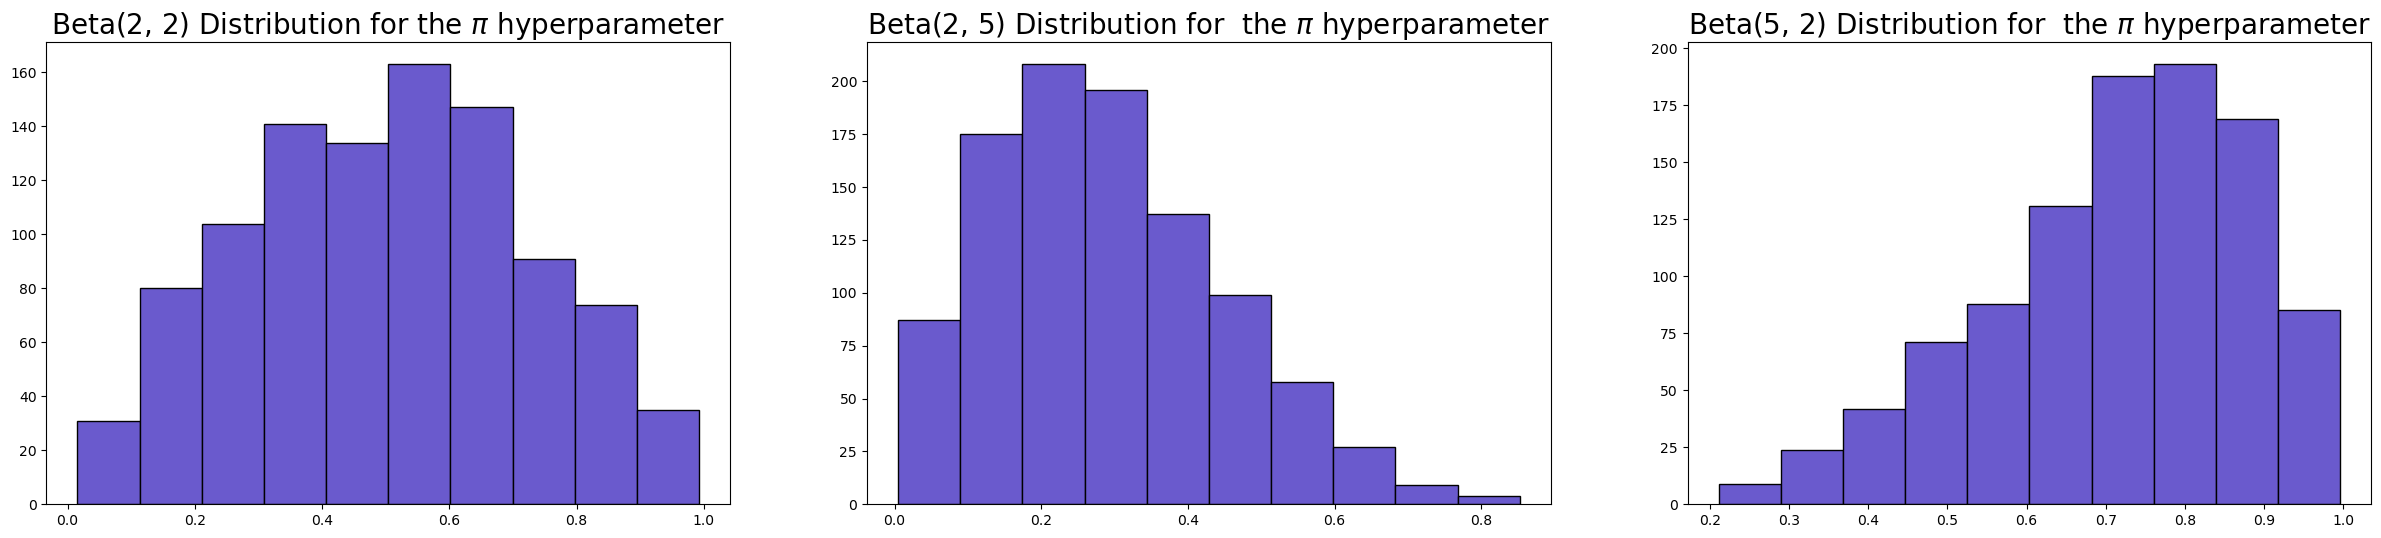

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(30, 6))
axs = axs.flatten()
axs[0].hist(pm.draw(pm.Beta.dist(2, 2), 1000), ec="black", color="slateblue")
axs[0].set_title(r"Beta(2, 2) Distribution for the $\pi$ hyperparameter", size=20)
axs[1].hist(pm.draw(pm.Beta.dist(2, 5), 1000), ec="black", color="slateblue")
axs[1].set_title(r"Beta(2, 5) Distribution for  the $\pi$ hyperparameter", size=20)
axs[2].hist(pm.draw(pm.Beta.dist(5, 2), 1000), ec="black", color="slateblue")
axs[2].set_title(r"Beta(5, 2) Distribution for  the $\pi$ hyperparameter", size=20);

We'll now fit two models and estimate the implied treatment effect. We compare two models, the first with a normal(0, 1) prior on the $\beta$ coefficients and then the same model that uses spike and slab priors on the input variables.

In [5]:
# =========================================================================
# Model 1: Normal priors (no selection)
# =========================================================================
print("\n" + "-" * 80)
print("Model 1: Normal Priors (No Variable Selection)")
print("-" * 80)

result_normal = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type=None,  # No variable selection
    priors={
        "mus": [0, 0],
        "sigmas": [1, 1],
        "eta": 1,
        "lkj_sd": 1,
    },
)

# =========================================================================
# Model 2: Spike-and-Slab priors
# =========================================================================
print("\n" + "-" * 80)
print("Model 2: Spike-and-Slab Priors")
print("-" * 80)

result_spike_slab = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type="spike_and_slab",
    vs_hyperparams={
        "pi_alpha": 2,
        "pi_beta": 2,
        "slab_sigma": 2,
        "temperature": 0.1,
        "outcome": True,
    },  # Include outcome variable selection
)


--------------------------------------------------------------------------------
Model 1: Normal Priors (No Variable Selection)
--------------------------------------------------------------------------------


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:137: UserWarning: Warning. The treatment variable is not Binary.
                We will use the multivariate normal likelihood
                for continuous treatment.
  self.input_validation()
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/3000 [00:01<?, ?it/s]


Running chain 0:   5%|▌         | 150/3000 [00:01<00:12, 225.97it/s]


Running chain 0:  10%|█         | 300/3000 [00:05<00:41, 65.41it/s] 


Running chain 0:  15%|█▌        | 450/3000 [00:08<00:45, 55.62it/s]


Running chain 0:  20%|██        | 600/3000 [00:11<00:48, 49.02it/s]




--------------------------------------------------------------------------------
Model 2: Spike-and-Slab Priors
--------------------------------------------------------------------------------


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/3000 [00:01<?, ?it/s]





Running chain 0:   5%|▌         | 150/3000 [00:12<03:23, 14.03it/s]

Running chain 0:  10%|█         | 300/3000 [00:23<03:20, 13.45it/s]


Running chain 0:  15%|█▌        | 450/3000 [00:35<03:12, 13.23it/s]


Running chain 0:  20%|██        | 600/3000 [00:46<03:02, 13.17it/s]




Running chain 0:  25%|██▌       | 750/3000 [00:58<02:52, 13.08it/s]


Running chain 0:  30%|███       | 900/3000 [01:09<02:40, 13.06it/s]


Running chain 0:  35%|███▌      | 1050/3000 [01:21<02:29, 13.01it/s]


Running chain 0:  40%|████      | 1200/3000 [01:33<02:18, 12.97it/s]


Running chain 0:  45%|████▌     | 1350/3000 [01:44<02:07, 12.93it/s]


Running chain 0:  50%|█████     | 1500/3000 [01:56<01:55, 12.94it/s]



Running chain 0:  50%|█████     | 1500/3000 [02:06<01:55, 12.94it/s]

Running chain 0:  55%|█████▌    | 1650/3000 [02:07<01:44, 12.95it/s]


Running chain 0:  60%|██████  

The models have quite a distinct structure. Compare the normal IV model with non variable selection priors. 

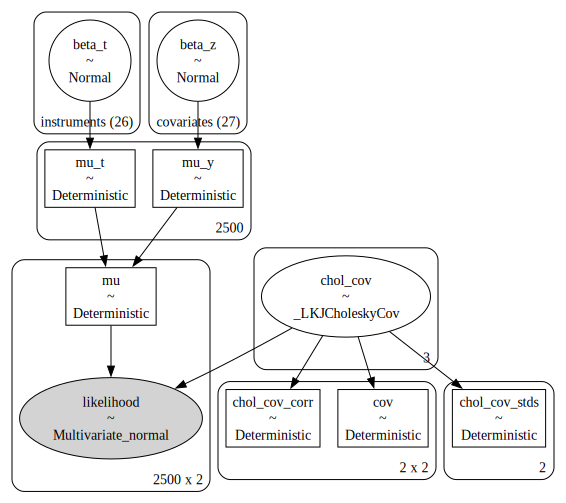

In [6]:
pm.model_to_graphviz(result_normal.model)

Now compare the structure of the spike and slab model. As before we're fitting a joint model of treatment and outcome. But now we specify hierarchical priors over the beta coefficients to "select" the variables of real importance. In the IV case this is particularly interesting because it helps mitigate the risk of over-parameterisation with weak instruments. In effect the sparsity priors act like a "instrument discovery" mechanism when used in this joint modelling context. 

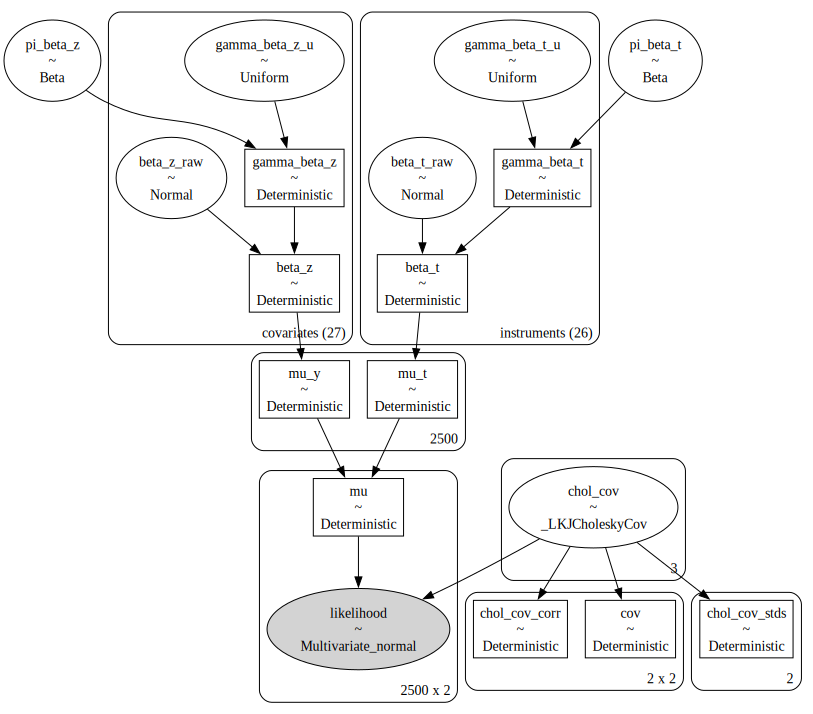

In [7]:
pm.model_to_graphviz(result_spike_slab.model)

Despite seeing some divergences in our spike and slab model, most other sampler health metrics seem healthy. The rhat values are all close to 1.0 and the effective sample sizes are reasonable. The divergences may be a sign that the temperature parameter could be adjusted, or that the the spike and slab prior is struggling to identify relevant variables in the presence of weak instruments.

And since we know the true data generating conditions we can also assess the derived posterior treatment estimates. This also lets us see a likely cause of the divergences, the model is torn between a slightly bi-modal distribution in the focal parameters as it oscillates between two plausible solutions for the treatment effect. 

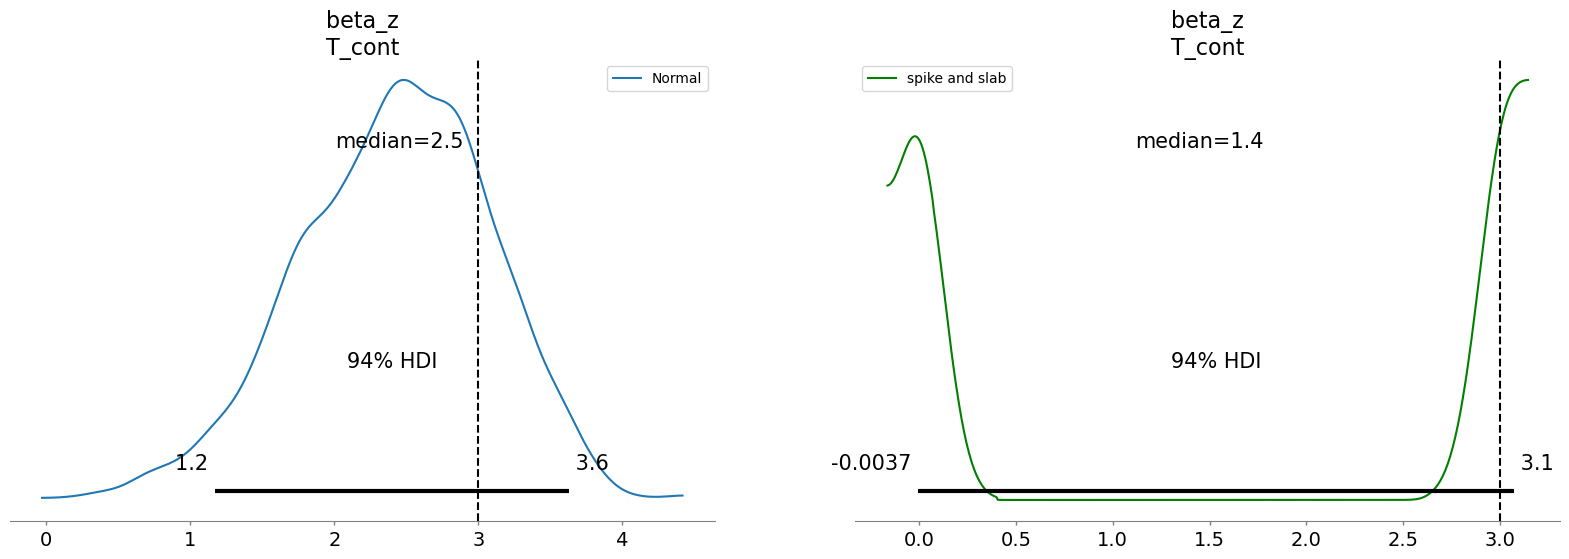

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
az.plot_posterior(
    result_normal.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=axs[0],
    label="Normal",
    point_estimate="median",
)
az.plot_posterior(
    result_spike_slab.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=axs[1],
    color="green",
    label="spike and slab",
    point_estimate="median",
)
axs[0].axvline(3, color="black", linestyle="--", label="True value")
axs[1].axvline(3, color="black", linestyle="--", label="True value");

This plot suggests that the spike and slab prior was split between 0'ing out our treatment and allocating it a mass around the true value. This will not always work but it is a sensible practice to at least sensitivity check difference between the estimates under different prior settings. We can observe how aggressively the spike and slab prior worked to cull or removal unwanted variables from each model by comparing the values on the coefficients across each model. We might want to adjust the level of aggression in the `temperature` hyperparameter. 

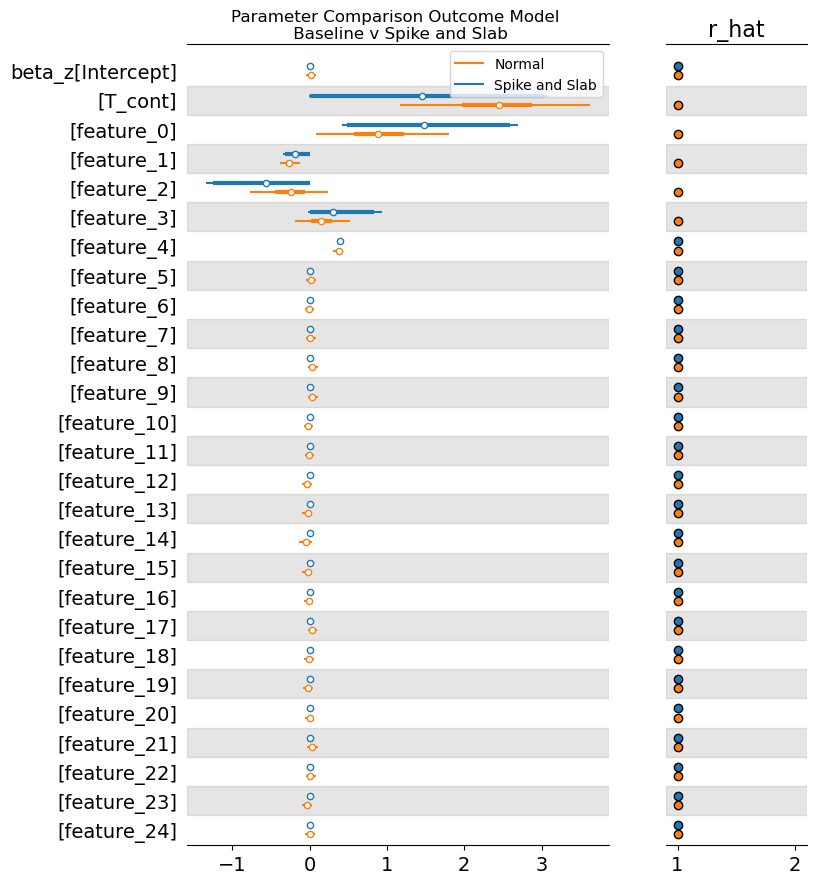

In [9]:
axs = az.plot_forest(
    [result_spike_slab.idata, result_normal.idata],
    var_names=["beta_z"],
    combined=True,
    model_names=["Spike and Slab", "Normal"],
    r_hat=True,
)
axs[0].set_title("Parameter Comparison Outcome Model \n Baseline v Spike and Slab");

The parameter estimates are healthy for both models. With the spike and slab being a little bit more aggressive. But differences are more pronounced in the regularisation of the instruments. 

#### The Treatment Model

Variable selection is applied to both the outcome and the treatment model. In this way we calibrate our parameters to the joint patterns of realisations between these two endogenous variables. The Normal model (with all covariates included) is the baseline, showing the impact of including many irrelevant variables. Its posterior is centered correctly but is generally wider, reflecting the increased uncertainty/variance due to the noise covariates.

The Spike-and-Slab prior performs better here. This suggests it was successful in decisively excluding the noise variables, reducing the model's overall variance.

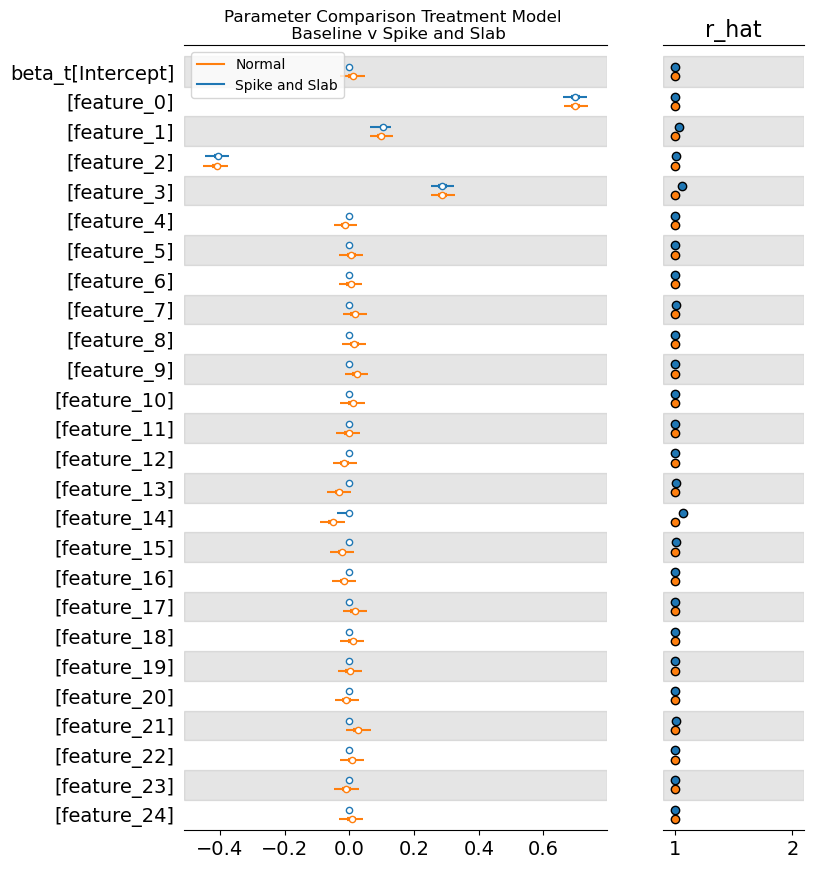

In [10]:
axs = az.plot_forest(
    [result_spike_slab.idata, result_normal.idata],
    var_names=["beta_t"],
    combined=True,
    model_names=["Spike and Slab", "Normal"],
    r_hat=True,
)

axs[0].set_title("Parameter Comparison Treatment Model \n Baseline v Spike and Slab");

The spike and slab prior can also output direct inclusion probabilities that can be used for communication regarding which variables were "selected" in the process.

In [11]:
summary = result_spike_slab.model.vs_prior_outcome.get_inclusion_probabilities(
    result_spike_slab.idata, "beta_z"
)
summary

,prob,selected,gamma_mean
0,0.00325,False,0.004184
1,0.50125,True,0.494873
2,0.84125,True,0.852563
3,0.30625,False,0.327865
4,0.44300,False,0.424835
5,0.42475,False,0.431005
6,0.68000,True,0.717154
7,0.00050,False,0.001664
8,0.00200,False,0.002970
9,0.00050,False,0.001433


### Horseshoe

The horsehoe prior takes a continuous philosophical stance. Instead of discrete selection, it says: effects exist on a spectrum from negligible to substantial, and we should shrink them proportionally to their signal strength.

It uses a hierarchical structure where the coefficient $\beta_j$ is determined by a global shrinkage parameter ($\tau$) and a local shrinkage parameter so that effects get pulled strongly toward zero (but rarely exactly zero) but there is a chance for counterfailing effects on each individual variable. Large effects escape shrinkage almost entirely, as if they are too big for the horseshoe's magnetic pull.This method embraces probabilistic humility. It's less decisive than the spike-and-slab, but it mitigates the risk of completely zeroing out the small, but real, contributions of certain variables — a risk that the spike-and-slab takes.

The key to the implementation is the hierarchical $\lambda$ component: 

$$ \tilde{\lambda}_j = \sqrt{\frac{c^2 \lambda_j^2}{c^2 + \tau^2 \lambda_j^2}} $$

is composed of individual local shrinkage parameters and $c^2$ is a regularization parameter that prevents over-shrinkage of genuinely large signals. 

#### The $\tau_0$ hyperparameter

Like the `temperature` parameter in the spike and slab model, the $\tau_{0}$ parameter determines the overall level of sparsity expected in the model. However, the $\tau_{0}$ will by default be derived from the data and the number of covariates in your data. While both the horseshoe and spike-and-slab priors address variable selection and sparsity, they embody fundamentally different philosophies about how to achieve these goals. The horseshoe embraces continuity, creating a smooth gradient of shrinkage where all coefficients remain in the model but are pulled toward zero with varying intensity. 

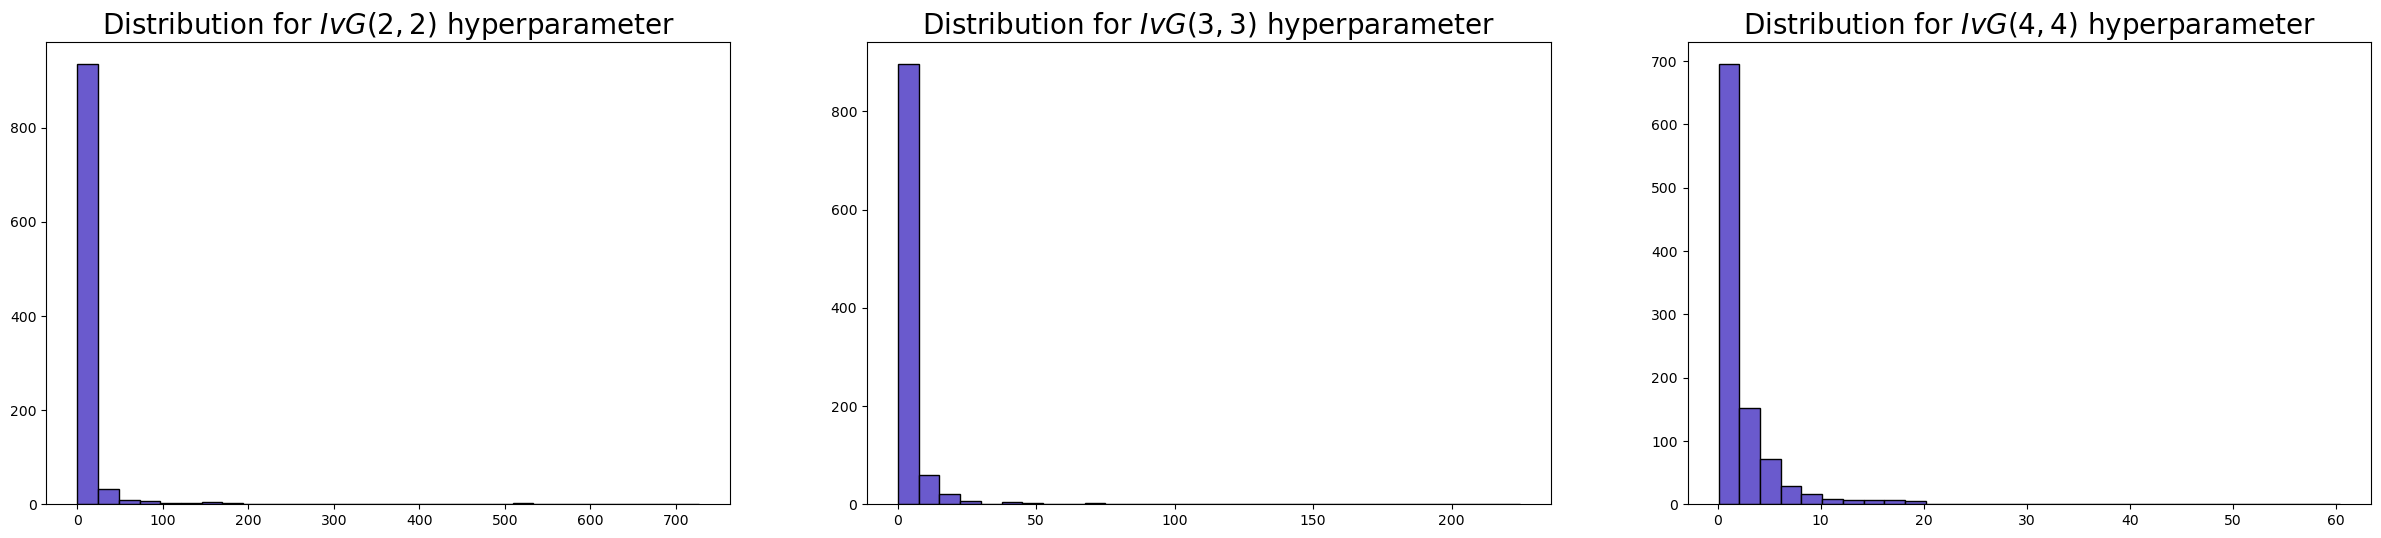

In [12]:
fig, axs = plt.subplots(1, 3, figsize=(30, 6))
axs = axs.flatten()
axs[0].hist(
    pm.draw(pm.InverseGamma.dist(2, 2), 1000) ** 2,
    ec="black",
    color="slateblue",
    bins=30,
)
axs[0].set_title(r"Distribution for $IvG(2, 2)$ hyperparameter", size=20)
axs[1].hist(
    pm.draw(pm.InverseGamma.dist(3, 3), 1000) ** 2,
    ec="black",
    color="slateblue",
    bins=30,
)
axs[1].set_title(r"Distribution for $IvG(3, 3)$ hyperparameter", size=20)
axs[2].hist(
    pm.draw(pm.InverseGamma.dist(4, 4), 1000) ** 2,
    ec="black",
    color="slateblue",
    bins=30,
)
axs[2].set_title(r"Distribution for $IvG(4, 4)$ hyperparameter", size=20);

In [13]:
# =========================================================================
# Model 2: Horseshoe priors
# =========================================================================
print("\n" + "-" * 80)
print("Model 3: Horseshoe Priors")
print("-" * 80)

result_horseshoe = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type="horseshoe",
    vs_hyperparams={"c2_alpha": 3, "c2_beta": 3, "outcome": True},
)


--------------------------------------------------------------------------------
Model 3: Horseshoe Priors
--------------------------------------------------------------------------------


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:137: UserWarning: Warning. The treatment variable is not Binary.
                We will use the multivariate normal likelihood
                for continuous treatment.
  self.input_validation()
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/pymc_models.py:900: UserWarning: Variable selection priors specified. The 'mus' and 'sigmas' in the priors dict will be ignored for beta coefficients in the treatment equation.Only 'eta' and 'lkj_sd' will be used from the priors dictwhere applicable.
  self.build_model(
Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/3000 [00:01<?, ?it/s]





Running chain 0:   5%|▌         | 150/3000 [00:12<03:31, 13.45it/s]


Running chain 0:  10%|█         | 300/3000 [00:24<03:26, 13.08it/s]


Running chain 0:  15%|█▌        | 450/3000 [00:36<03:22, 12.61i

Similar to the inclusion probabilities in the spike and slab model, a horseshoe model can output the relative shrinkage factor that gets applied to each variables inclusion. This method of variable is less decisive than spike and slab, but also mitigates case of completely zero-ing the small but real contributions of certain variables.

In [14]:
summary = result_horseshoe.model.vs_prior_outcome.get_shrinkage_factors(
    result_horseshoe.idata, "beta_z"
)
summary

,shrinkage_factor,lambda_tilde,tau
0,0.008193,1.284430,0.007954
1,1.378144,216.060102,0.007954
2,0.630441,98.838130,0.007954
3,0.367299,57.583736,0.007954
4,0.091722,14.379803,0.007954
5,0.073104,11.460933,0.007954
6,0.465154,72.925074,0.007954
7,0.009195,1.441513,0.007954
8,0.009396,1.473050,0.007954
9,0.009030,1.415615,0.007954


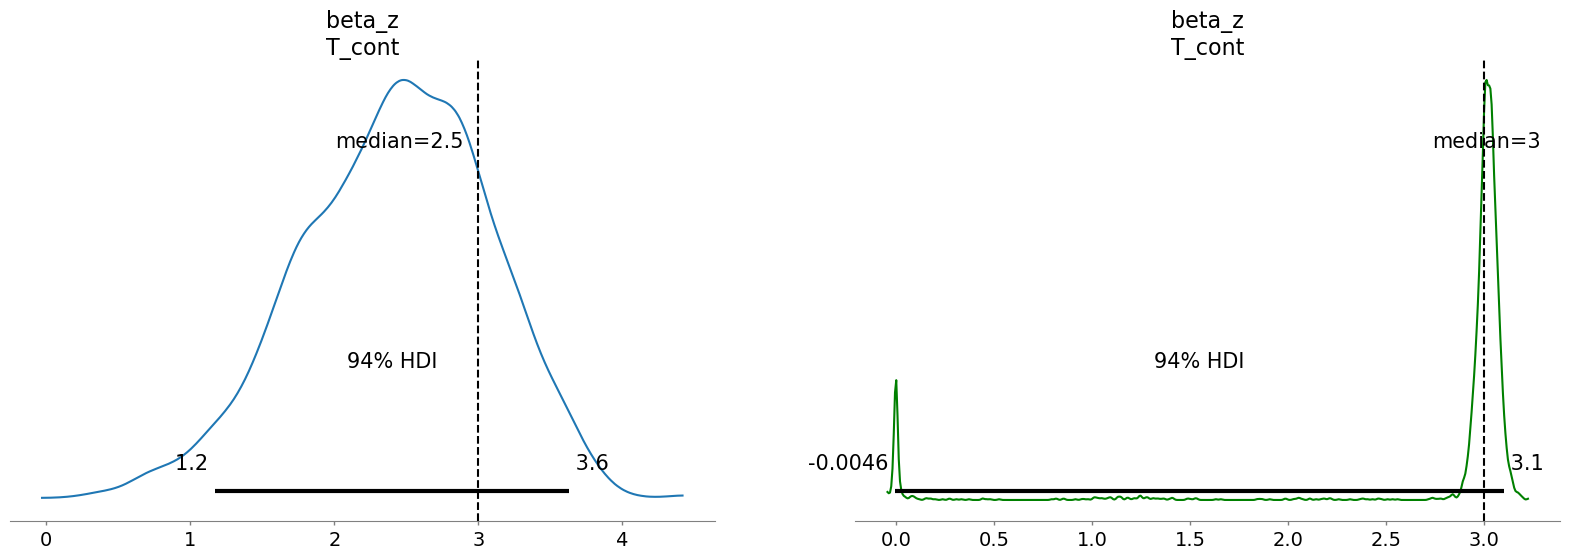

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
az.plot_posterior(
    result_normal.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=axs[0],
    point_estimate="median",
)
az.plot_posterior(
    result_horseshoe.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_cont"]},
    ax=axs[1],
    color="green",
    point_estimate="median",
)
axs[0].axvline(3, color="black", linestyle="--")
axs[1].axvline(3, color="black", linestyle="--");

In this case it seems the horseshoe prior is also able to recover the true value of the treatment effect, and does so more confidently than in the simpler IV with normal(0, 1) regularisation. 

### Binary Treatment Case

Our data generating function output two different simulation scenarios, where the treatment was either continuous or binary. This allows us to demonstrate the joint modelling of the binary treatment outcome which uses a Bernoulli likelihood for the treatment variable and latent confounding to model the joint realisation of treatment and outcome. 

This model estimates causal effects in settings with a binary, potentially endogenous treatment and a continuous outcome using a Bayesian control-function approach. It is designed for applications where standard linear instrumental variables methods are inappropriate due to the discrete nature of the treatment, but where full joint latent-variable models (e.g. bivariate probit) are either undesirable or overly restrictive. Additionally, the bivariate probit model assumes a normal distribution for the latent treatment error, which may not be suitable in all contexts and can be less stable in practice than logistic specifications.

The model consists of a treatment equation and an outcome equation, linked through dependence in their unobserved components.

#### Treatment equation

The binary treatment variable $t_i \in \{0,1\}$ is modeled using a logistic latent-index formulation:

$$
t_i = \mathbb{1}\{ Z_i \beta_t + V_i > 0 \},
$$

where $Z_i$ is a vector of instrumental variables (and optional covariates), $\beta_t$ is a vector of first-stage coefficients, and $V_i$ is an unobserved disturbance. The latent error term follows a standard Logistic distribution,

$$
V_i \sim \text{Logistic}(0,1).
$$

This specification implies a logistic link for the treatment assignment mechanism, but the coefficients $\beta_t$ should not be interpreted as marginal log-odds effects as in a standard logistic regression, since the latent disturbance $V_i$ is explicitly represented rather than integrated out.

#### Outcome equation

The continuous outcome $y_i$ is modeled as

$$
y_i = X_i \beta_z + U_i,
$$

where $X_i$ contains observed covariates (including the treatment), $\beta_z$ are outcome coefficients, and the outcome error term satisfies

$$
U_i \sim \mathcal{N}(0, \sigma_U^2).
$$

Under standard instrumental variables assumptions, the coefficient on the treatment in $\beta_z$ has a causal interpretation and may be interpreted as a local average treatment effect (LATE).

#### Endogeneity and control function

Endogeneity arises when the treatment error $V_i$ is correlated with the outcome error $U_i$. Rather than specifying a fully joint likelihood for $(V_i, U_i)$, the model adopts a control-function formulation that allows the conditional mean of $U_i$ to depend on $V_i$.

Specifically, the model assumes

$$
\mathbb{E}[U_i \mid V_i]
= \rho \cdot \frac{\sigma_U}{\sigma_V} \cdot V_i,
$$

where $\rho \in (-1,1)$ is a dependence or sensitivity parameter and $\sigma_V^2 = \pi^2 / 3$ is the variance of a standard Logistic random variable. Conditional on $V_i$, the outcome error is approximated as

$$
U_i \mid V_i \sim
\mathcal{N}\!\left(
\rho \frac{\sigma_U}{\sigma_V} V_i,\;
\sigma_U^2 (1 - \rho^2)
\right).
$$

This variance-matching approximation treats the Logistic disturbance as if it were Normal with the same variance. As a result, $\rho$ should not be interpreted as a Pearson correlation coefficient between latent errors. Instead, it serves as a sensitivity parameter that controls the strength and direction of unobserved confounding.

When $\rho = 0$, the treatment is conditionally exogenous given covariates, and the model reduces to a standard outcome regression. As $|\rho|$ increases, the contribution of the control function becomes stronger, reflecting greater endogeneity.

#### Prior specification

Regression coefficients may be assigned standard Normal priors or variable-selection priors such as spike-and-slab formulations. When variable selection is enabled, coefficient-level mean and variance priors are ignored in favor of the selection prior.

The dependence parameter $\rho$ is parameterized via a transformed unconstrained variable:

$$
\rho = \tanh(\rho^{*}),
\qquad
\rho^{*} \sim \mathcal{N}(0, 0.5).
$$

This prior concentrates mass near zero, regularizing weakly identified models and encouraging conservative estimates of endogeneity. Optional bounds may be imposed on $\rho$ to support explicit sensitivity analysis.

#### Identification assumptions

Identification relies on standard instrumental variables assumptions: instrument relevance, exclusion, and independence from unobserved outcome determinants. In addition, the model assumes that the logistic specification for treatment assignment and the linear specification for the outcome are adequate approximations to the underlying data-generating process.

#### Interpretation and scope

This model provides a Bayesian instrumental variables estimator for binary treatments that emphasizes transparency and sensitivity analysis over full likelihood coherence. It is not equivalent to a bivariate probit or other fully joint latent-variable model, and the dependence parameter does not correspond to a true correlation between latent errors. Nevertheless, it offers a practical and interpretable framework for causal inference in applied settings where binary endogeneity is a central concern. The same variable selection priors discussed earlier can be applied to both treatment and outcome equations to help identify relevant predictors and instruments. Which we will do now. 


In [16]:
formula = "Y_bin ~ T_bin + " + " + ".join(features)
instruments_formula = "T_bin ~ 1 + " + " + ".join(features)


# =========================================================================
# Model 1: Normal priors (no selection)
# =========================================================================
print("\n" + "-" * 80)
print("Model 1: Normal Priors Binary Treatment (No Variable Selection)")
print("-" * 80)

result_normal_binary = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type=None,  # No variable selection
    binary_treatment=True,
    priors={
        "mus": [0, 0],
        "sigmas": [1, 1],
        "eta": 1,
        "lkj_sd": 1,
    },
)


result_horseshoe_binary = cp.InstrumentalVariable(
    instruments_data=instruments_data,
    data=data,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type="horseshoe",
    vs_hyperparams={"c2_alpha": 3, "c2_beta": 3, "outcome": True},
    binary_treatment=True,
)


--------------------------------------------------------------------------------
Model 1: Normal Priors Binary Treatment (No Variable Selection)
--------------------------------------------------------------------------------


Compiling.. :   0%|          | 0/3000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/3000 [00:00<?, ?it/s]



Running chain 0:   5%|▌         | 150/3000 [00:17<05:20,  8.89it/s]




Running chain 0:  10%|█         | 300/3000 [00:20<02:28, 18.16it/s]


Running chain 0:  15%|█▌        | 450/3000 [00:22<01:33, 27.41it/s]


Running chain 0:  20%|██        | 600/3000 [00:24<01:05, 36.76it/s]




Running chain 0:  25%|██▌       | 750/3000 [00:26<00:49, 45.80it/s]


Running chain 0:  30%|███       | 900/3000 [00:27<00:39, 53.81it/s]


Running chain 0:  35%|███▌      | 1050/3000 [00:29<00:32, 60.72it/s]


Running chain 0:  40%|████      | 1200/3000 [00:31<00:27, 66.35it/s]


Running chain 0:  45%|████▌     | 1350/3000 [00:33<00:23, 70.65it/s]


Running chain 0:  50%|█████     | 1500/3000 [00:35<00:20, 73.91it/s]


Running chain 0:  55%|█████▌    | 1650/3000 [00:36<00:17, 76.32it/s]


Running chain 0:  60%|██████    | 1800/3000 [00:38<00:15, 78.24it/s]


Running chain 0:  65%|██████▌

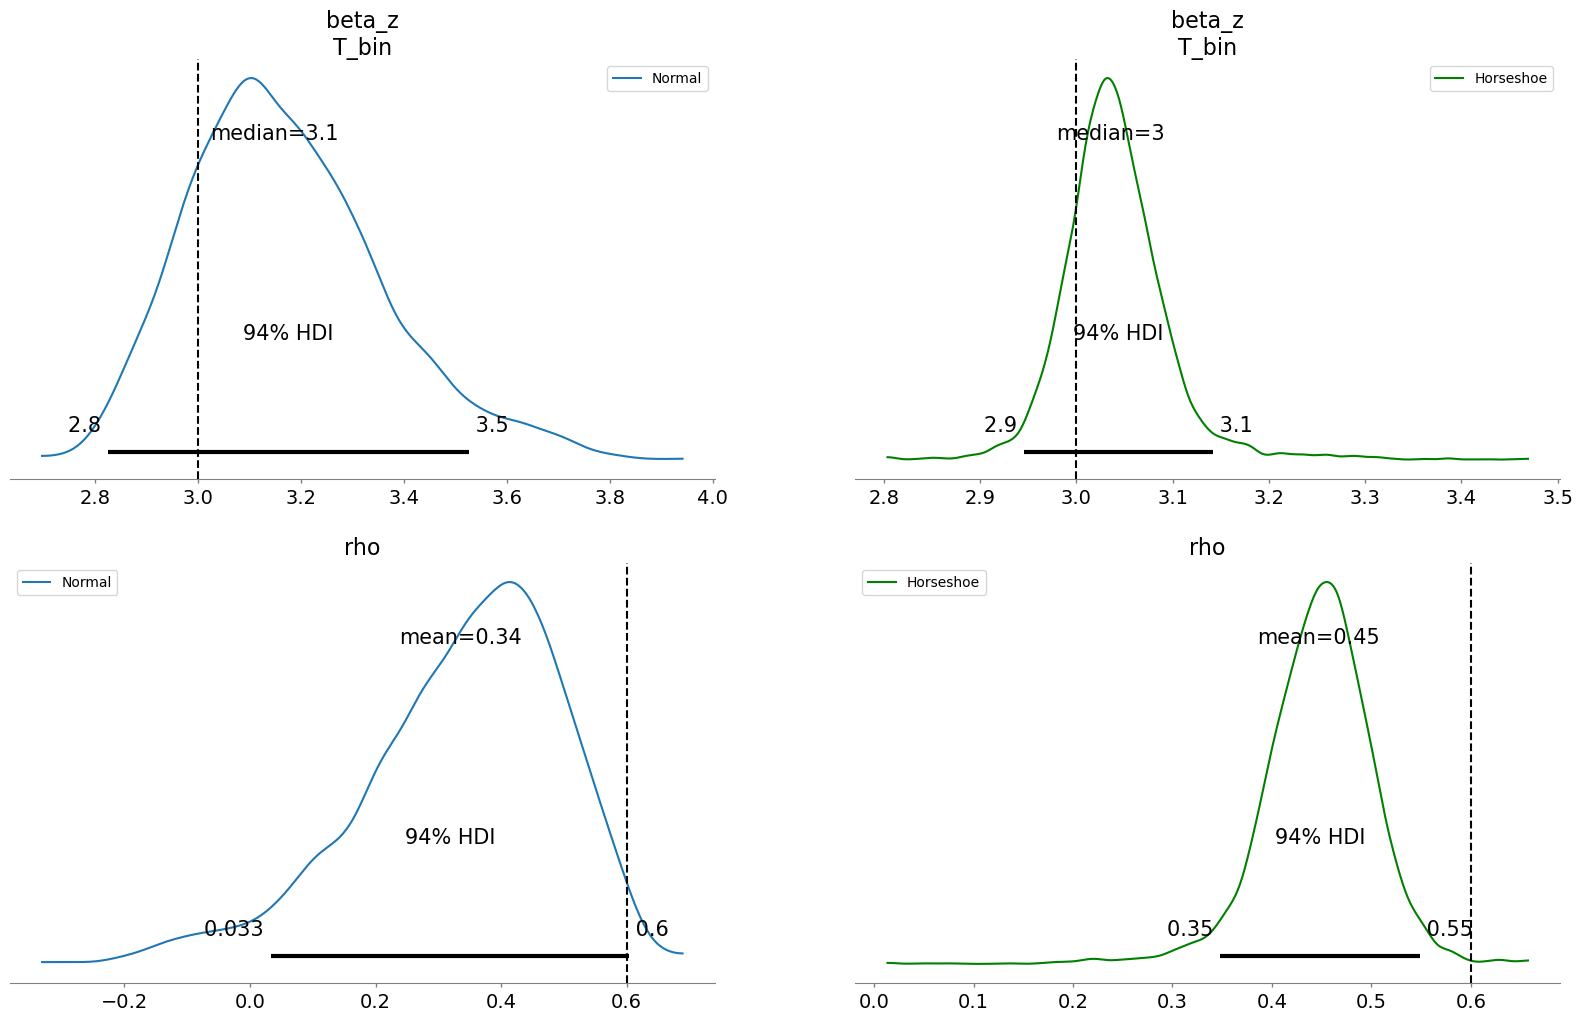

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
axs = axs.flatten()
az.plot_posterior(
    result_horseshoe_binary.idata,
    var_names=["beta_z"],
    coords={"covariates": ["T_bin"]},
    ax=axs[1],
    label="Horseshoe",
    color="green",
    point_estimate="median",
)
az.plot_posterior(
    result_normal_binary.idata,
    var_names=["beta_z", "rho"],
    coords={"covariates": ["T_bin"]},
    ax=axs[0],
    label="Normal",
    point_estimate="median",
)
axs[0].axvline(3, color="black", linestyle="--")
axs[1].axvline(3, color="black", linestyle="--")
az.plot_posterior(
    result_horseshoe_binary.idata,
    var_names=["rho"],
    ax=axs[3],
    color="green",
    label="Horseshoe",
)
az.plot_posterior(
    result_normal_binary.idata,
    var_names=["rho"],
    ax=axs[2],
    label="Normal",
)
axs[2].axvline(0.6, color="black", linestyle="--")
axs[3].axvline(0.6, color="black", linestyle="--");

In the Binary case the biases due to weak instruments are overcome by both modelling strategies recovering the treatment effect well. But here as before, the uncertainty bounds on the treatment estimate are better approximated with the variable selection prior. Additionally, the rho parameter reflects correlation between the treatment and outcome errors on the logistic scale that is not fully resolved by either model. This doesn't recover the true value that we set in the data generating process, but additionally we're not modelling rho in the same way. The point is to use the control function to diagnose latent confounding and correct for it to recover the true treatment effect. The scale at which we model rho is somewhat immaterial so long as we can recover the true treatment effect. Both models do this well in this case.

### An Applied Example: Weak but non-zero Instruments

We now will explore the distinct challenges of using the Nevo cereal dataset—a cornerstone of industrial organization literature. While we've seen how "sparsity" or variable selection priors like the Horseshoe can work nicely with their ability to navigate high-dimensional spaces, they often encounter severe pathological bottlenecks when faced with weak instruments. 

In the Nevo context, where instruments typically consist of prices in distant geographic markets (Hausman instruments), the signal-to-noise ratio is frequently too low to satisfy the aggressive "spike" of a shrinkage prior. This leads to a fragmented posterior where MCMC chains become trapped in local modes—either zeroing out crucial but weak signals or over-extending into the heavy tails—resulting in the high $\hat{R}$ and low Effective Sample Size (ESS) observed in earlier runs. To illustrate these trade-offs, we will systematically compare the Regularized Horseshoe against a baseline Normal(0, 1) prior. We will demonstrate how the smooth, convex geometry of the Normal prior provides a more navigable energy landscape for the NUTS sampler, ensuring stable convergence at the cost of less selective regularization. By visualizing the rank plots and posterior densities of both approaches, we aim to show that for weakly identified structural models, the "best" prior is often the one that prioritizes sampling stability and global identification over aggressive variable selection. As usual, the answer is to the question of which prior to use, is driven by what influence you expect your variables to have in the model. 



In [18]:
import causalpy as cp

df_nevo = pd.read_csv("../../../causalpy/data/data_nevo.csv", decimal=",")
df_nevo["log_share"] = np.log(df_nevo["share"])
df_nevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2256 entries, 0 to 2255
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         2256 non-null   int64  
 1   firmbr     2256 non-null   int64  
 2   firm       2256 non-null   int64  
 3   brand      2256 non-null   int64  
 4   city       2256 non-null   int64  
 5   year       2256 non-null   int64  
 6   quarter    2256 non-null   int64  
 7   share      2256 non-null   float64
 8   price      2256 non-null   float64
 9   sugar      2256 non-null   float64
 10  mushy      2256 non-null   float64
 11  z1         2256 non-null   float64
 12  z2         2256 non-null   float64
 13  z3         2256 non-null   float64
 14  z4         2256 non-null   float64
 15  z5         2256 non-null   float64
 16  z6         2256 non-null   float64
 17  z7         2256 non-null   float64
 18  z8         2256 non-null   float64
 19  z9         2256 non-null   float64
 20  z10     

In [19]:
ols_formula = "log_share ~ price + sugar + mushy"
ols_res = ols(ols_formula, data=df_nevo).fit()
ols_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_share   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     66.33
Date:                Wed, 07 Jan 2026   Prob (F-statistic):           4.26e-41
Time:                        17:26:36   Log-Likelihood:                -3424.2
No. Observations:                2256   AIC:                             6856.
Df Residuals:                    2252   BIC:                             6879.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7173      0.107    -34.870      0.000      -3.926      -3.508
price         -9.6336      0.840    -11.473      0.000     -11.280      -7.987
sugar          0.0454      0.004     10.825      0.000       0.037       0.054
mushy          0.0550      0.050      1.109      0.268      -0.042       0.152
==============================================================================
Omnibus:                       13.848   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.044
Skew:                          -0.193   Prob(JB):                     0.000892
Kurtosis:                       2.969   Cond. No.                         379.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
instruments = [col for col in df_nevo.columns if "z" in col]
instruments_formula = "price ~ 1 + sugar + mushy + " + " + ".join(instruments)
instruments_formula
formula = "log_share ~ price + sugar + mushy"

In [21]:
sample_kwargs = {
    "draws": 1000,
    "tune": 1000,
    "chains": 4,
    "cores": 4,
    "target_accept": 0.9,
    "progressbar": True,
    "random_seed": 42,
    "nuts_sampler": "numpyro",
}
result_horseshoe_nevo = cp.InstrumentalVariable(
    instruments_data=df_nevo,
    data=df_nevo,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type="horseshoe",
    vs_hyperparams={"outcome": False, "c2_alpha": 2, "c2_beta": 8, "nu": 5},
    binary_treatment=False,
)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:137: UserWarning: Warning. The treatment variable is not Binary.
                We will use the multivariate normal likelihood
                for continuous treatment.
  self.input_validation()
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/pymc_models.py:900: UserWarning: Variable selection priors specified. The 'mus' and 'sigmas' in the priors dict will be ignored for beta coefficients in the treatment equation.Only 'eta' and 'lkj_sd' will be used from the priors dictwhere applicable.
  self.build_model(
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]




Running chain 0:   5%|▌         | 100/2000 [00:05<01:14, 25.66it/s]


Running chain 0:  10%|█         | 200/2000 [00:10<01:24, 21.29it/s]


Running chain 0:  15%|█▌        | 300/2000 [00:16<01:27, 19.54it

In [22]:
sample_kwargs = {
    "draws": 1000,
    "tune": 1000,
    "chains": 4,
    "cores": 4,
    "target_accept": 0.9,
    "progressbar": True,
    "random_seed": 42,
    "nuts_sampler": "numpyro",
}

result_nevo = cp.InstrumentalVariable(
    instruments_data=df_nevo,
    data=df_nevo,
    instruments_formula=instruments_formula,
    formula=formula,
    model=cp.pymc_models.InstrumentalVariableRegression(sample_kwargs=sample_kwargs),
    vs_prior_type=None,
    vs_hyperparams=None,
    binary_treatment=False,
    priors={
        "mus": [0, 0],
        "sigmas": [1, 5],
        "eta": 1,
        "lkj_sd": 1,
    },
)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/causalpy/experiments/instrumental_variable.py:137: UserWarning: Warning. The treatment variable is not Binary.
                We will use the multivariate normal likelihood
                for continuous treatment.
  self.input_validation()
Compiling.. :   0%|          | 0/2000 [00:00<?, ?it/s]





Running chain 0:   0%|          | 0/2000 [00:01<?, ?it/s]




Running chain 0:   5%|▌         | 100/2000 [00:02<00:17, 109.87it/s]


Running chain 0:  10%|█         | 200/2000 [00:06<00:56, 31.92it/s] 


Running chain 0:  15%|█▌        | 300/2000 [00:12<01:09, 24.59it/s]


Running chain 0:  25%|██▌       | 500/2000 [00:22<01:11, 21.04it/s]


Running chain 0:  30%|███       | 600/2000 [00:27<01:09, 20.22it/s]


Running chain 0:  35%|███▌      | 700/2000 [00:33<01:06, 19.67it/s]


Running chain 0:  40%|████      | 800/2000 [00:38<01:02, 19.25it/s]


Running chain 0:  45%|████▌     | 900/2000 [00:43<00:57, 19.04it/s]


The parameter estimates suggest a robust finding where the instrumental variable design has accounted for some of the bias in the OLS estimate and corrected for unobserved endogeniety. 

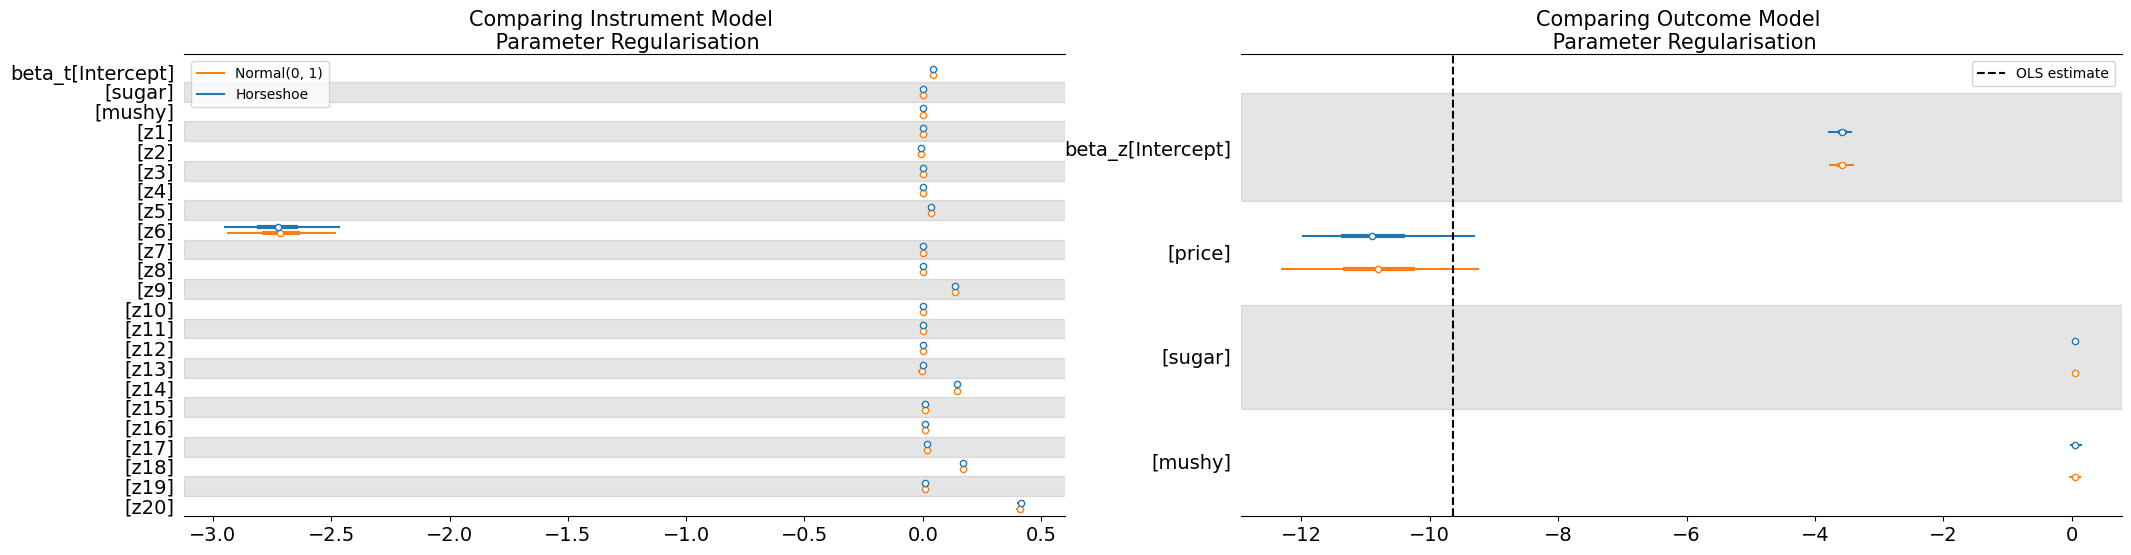

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(25, 6))
axs = axs.flatten()
az.plot_forest(
    [result_horseshoe_nevo.idata, result_nevo.idata],
    var_names=["beta_t"],
    combined=True,
    model_names=["Horseshoe", "Normal(0, 1)"],
    ax=axs[0],
)
az.plot_forest(
    [result_horseshoe_nevo.idata, result_nevo.idata],
    var_names=["beta_z"],
    combined=True,
    model_names=["Horseshoe", "Normal(0, 1)"],
    ax=axs[1],
)
axs[1].set_title("Comparing Outcome Model \n Parameter Regularisation", fontsize=15)
axs[0].set_title("Comparing Instrument Model \n Parameter Regularisation", fontsize=15)
axs[1].axvline(ols_res.params["price"], linestyle="--", label="OLS estimate", color="k")
axs[1].legend()

The own-price elasticity of demand measures the percentage change in a product’s market share resulting from a one-percent change in its price and is a primary indicator of market competitiveness and substitution patterns. Products with elastic demand (elasticity less than −1) face strong competitive pressure, while inelastic demand suggests limited substitution and potentially implausible market power in differentiated-product settings such as ready-to-eat cereals. 

Viewing the Nevo results through the distribution of product-level elasticities is therefore crucial, because economic plausibility is defined at the product level rather than by a single price coefficient. Small differences in the estimated price effect can translate into qualitatively different elasticity implications across products due to heterogeneity in prices and market shares. Comparing elasticity distributions across OLS and IV specifications highlights how correcting for price endogeneity shifts mass away from implausibly inelastic demand, while the choice of prior further shapes dispersion and tail behavior. This elasticity-based perspective provides a transparent and policy-relevant diagnostic of how modeling choices propagate into substantive conclusions about competition and demand in the Nevo dataset.

In [24]:
alpha_horseshoe = az.summary(result_horseshoe_nevo.idata, var_names=["beta_z"])[
    "mean"
].loc["beta_z[price]"]
alpha_normal = az.summary(result_nevo.idata, var_names=["beta_z"])["mean"].loc[
    "beta_z[price]"
]
alpha_ols = ols_res.params["price"]

elas_ols = alpha_ols * df_nevo["price"] * (1 - df_nevo["share"])
elas_normal = alpha_normal * df_nevo["price"] * (1 - df_nevo["share"])
elas_horseshoe = alpha_horseshoe * df_nevo["price"] * (1 - df_nevo["share"])

print("Inelastic (OLS):", (elas_ols >= -1).sum())
print("Inelastic (Normal IV):", (elas_normal >= -1).sum())
print("Inelastic (Horseshoe IV):", (elas_horseshoe >= -1).sum())

Inelastic (OLS): 586
Inelastic (Normal IV): 292
Inelastic (Horseshoe IV): 276


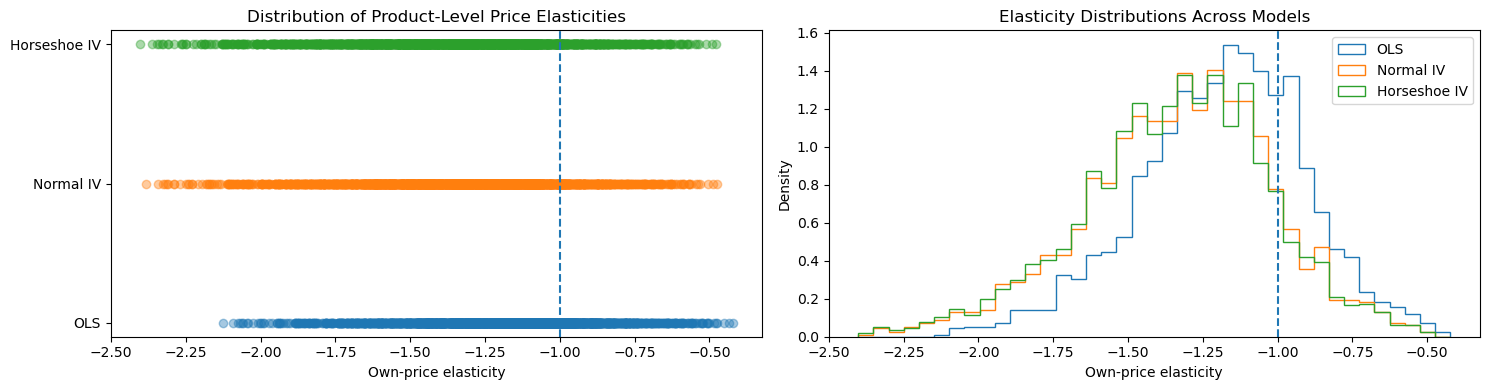

In [25]:
elas = {
    "OLS": elas_ols.values,
    "Normal IV": elas_normal.values,
    "Horseshoe IV": elas_horseshoe.values,
}

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs = axs.flatten()
ax = axs[0]
ax1 = axs[1]
y_positions = np.arange(len(elas))

for i, (label, values) in enumerate(elas.items()):
    y = np.full_like(values, i, dtype=float)
    ax.scatter(values, y, alpha=0.4)

ax.set_yticks(y_positions)
ax.set_yticklabels(list(elas.keys()))
ax.axvline(-1, linestyle="--")  # unit elasticity reference

ax.set_xlabel("Own-price elasticity")
ax.set_title("Distribution of Product-Level Price Elasticities")

bins = np.linspace(
    min(v.min() for v in elas.values()), max(v.max() for v in elas.values()), 40
)

for label, values in elas.items():
    ax1.hist(values, bins=bins, density=True, histtype="step", label=label)

ax1.axvline(-1, linestyle="--")
ax1.set_xlabel("Own-price elasticity")
ax1.set_ylabel("Density")
ax1.legend()
ax1.set_title("Elasticity Distributions Across Models")

plt.tight_layout()
plt.show()

#### Comparing Sampling Regimes

Despite roughly comparable IV results, we can now examine the trace plots to see how the horseshoe prior seems to struggle with sampling some of the values. The black bars on the left indicating divergences and the rank-bar plots on the right suggesting inconsistency across the sampling chains as they exceed the boundary of the uniform distribution on chains. 

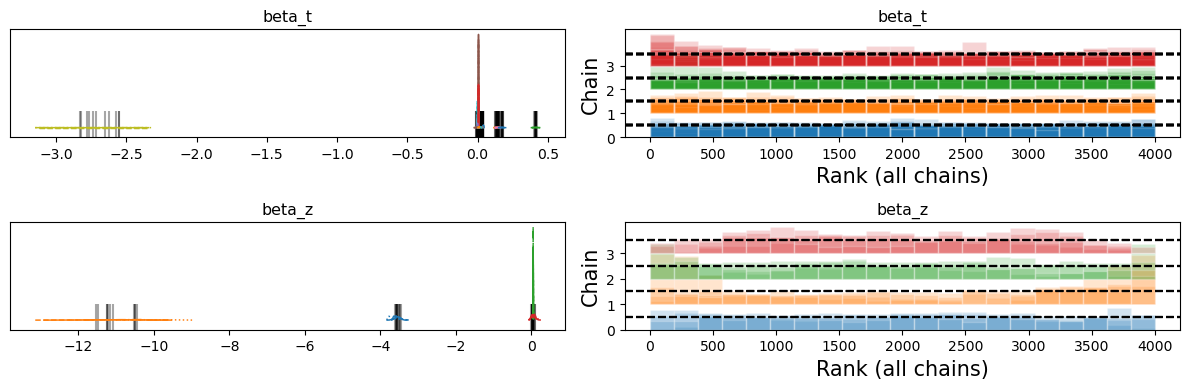

In [26]:
az.plot_trace(
    result_horseshoe_nevo.idata, var_names=["beta_t", "beta_z"], kind="rank_bars"
)
plt.tight_layout()

Conversely, the normal(0, 1) regularisation works much better and samples effectively and consistently across the chains. 

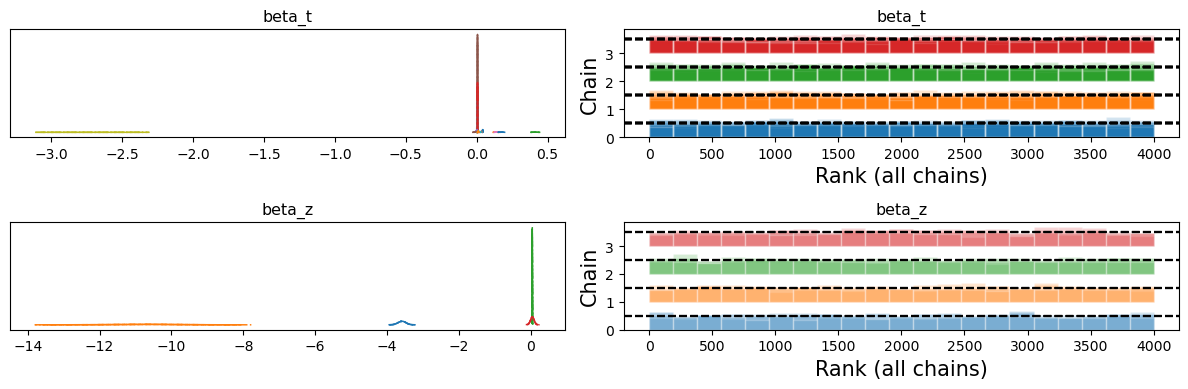

In [27]:
az.plot_trace(result_nevo.idata, var_names=["beta_t", "beta_z"], kind="rank_bars")
plt.tight_layout()

This demonstration shows that the Horseshoe regularisation can identify signal in the data, but where we have weak instruments, it gets caught deciding how strongly to zero-out the near zero coefficients. When chains disagree on how decisively to zero out these predictors the sampling can get stuck. 


### Conclusion: Choosing Your Path Through Uncertainty

Variable selection priors offer a principled way to navigate the tension between model complexity and causal identification. Rather than forcing binary decisions about which variables to include, these priors encode our uncertainty about variable relevance directly into the inferential framework. But as we've seen, the choice between spike-and-slab and horseshoe reflects deeper commitments about how sparsity manifests in the world.

**The spike-and-slab prior** embodies decisiveness. It asks: which variables truly matter? By pushing coefficients toward exactly zero or allowing them to take on substantial values, it produces interpretable inclusion probabilities that clearly communicate which predictors the model has "selected." This approach shines when you believe that many potential confounders are genuine noise—included out of caution but ultimately irrelevant to the causal mechanism. The discrete nature of selection also makes results easier to communicate to stakeholders who think in terms of "what factors matter?" 

**The horseshoe prior** embraces nuance. It acknowledges that effects exist on a continuum, and that small but real contributions shouldn't be entirely zeroed out. The continuous shrinkage allows weak signals to persist (heavily damped) while strong signals emerge largely unscathed. This is valuable when you suspect that multiple confounders have genuine but varying degrees of influence, and when premature exclusion of any single variable might introduce bias. The regularization parameter $c^2$ acts as a safeguard, preventing even the horseshoe's aggressive shrinkage from overwhelming genuinely large effects.
 
In our simulations, both approaches identified the true treatment effect of 3, though they arrived there differently. The spike-and-slab showed more confidence, producing tighter posterior intervals by decisively excluding noise variables. The horseshoe's bi-modal posterior in some specifications revealed its uncertainty about the appropriate level of sparsity a kind of probabilistic humility that spike-and-slab's discrete choices don't allow.

#### Practical Guidance
 
- **Use spike-and-slab when** you have strong priors about sparsity (many potential confounders, few true ones), when interpretability matters (stakeholders want to know "what's included?"), or when you're willing to trade some flexibility for more decisive inference.
 
- **Use horseshoe when** you're uncertain about sparsity levels, when small effects might still matter for causal identification, or when you want the model to smoothly adapt its shrinkage to the data without hard inclusion/exclusion decisions.
 
- **Use neither when** theory clearly identifies your confounders, when sample size is large relative to the number of predictors, or when the cost of Type I errors (including irrelevant variables) is low relative to Type II errors (excluding true confounders)
 
#### Final Thoughts
 
Variable selection priors don't eliminate the need for causal reasoning. They don't tell you which variables are *causally* relevant, only which are *statistically* predictive. But when used thoughtfully—guided by theory about potential confounders, informed by domain knowledge about likely sparsity patterns, and validated through sensitivity analysis. They offer a middle path between the Scylla of over-specification (including everything) and the Charybdis of under-specification (excluding too much). Used within a joint model of treatment and outcome variable, the argument of a variable selection routine  represents an attempt to calibrate the parameters to select the instrument structure. What variable selection is really doing in joint treatment-outcome models is calibrating the parameters to discover patterns consistent with instrument structure *if such structure exists in the data*. The horseshoe shrinks away coefficients that appear redundant given the covariance structure between treatment, outcome, and covariates. The spike-and-slab actively excludes variables that don't contribute to explaining either margin after accounting for shared variation.
 
The ideal use of variable selection in instrumental variable designs is not as a replacement for domain knowledge but as a consistency check. The real power of these methods lies not in automation but in transparency. By making variable selection part of the posterior distribution rather than a pre-processing step, we can quantify and communicate our uncertainty about model structure itself. This moves us closer to the goal of all principled causal inference: not just estimating effects, but understanding the limits of what we can learn from the data we have.
 
As always in causal inference, the model is a question posed to the data. Variable selection priors help us ask that question more precisely, but we still need theory to tell us if we're asking the right question at all.

